# Importing Libraryies

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

* Pandas Option

In [3]:
pd.set_option('max_columns', None)

* Tqdm Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint Import

In [5]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [6]:
df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME
0,19.406000,0.475704,1.789,64.497482,167.582153,1.574993,NaN,493.493134,15_9-12
1,19.406000,0.479429,1.754,62.406261,167.425064,1.569011,NaN,493.645538,15_9-12
2,19.406000,0.474963,1.778,62.629055,167.808395,1.578010,NaN,493.797943,15_9-12
3,19.452999,0.504394,1.642,65.998596,169.244873,1.586024,NaN,493.950348,15_9-12
4,19.452999,0.480163,1.563,64.997223,170.635086,1.603011,NaN,494.102722,15_9-12


# Lithology Code Prediction

In [7]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [8]:
len(litho_data)

1294715

    * Converting Lithology Data to Integer

In [9]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

    * Reducing Dataset Size

In [10]:
litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.4, .6], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [11]:
print(train.shape, litho_data.shape)

(519041, 9) (1294715, 9)


    * Dataset Split

In [12]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [13]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (332185, 7) (332185,)
### Validation Dataset: ###  (83047, 7) (83047,)
### Test Dataset: ###  (103809, 7) (103809,)


In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)
x_test = std_scaler.fit_transform(x_test)

    * Hyper-Parameter Tunning --> Random Search

        * Parameter Grid Definition

In [15]:
grid = {
    "n_a": [4, 8, 16, 32, 64, 128],
    "n_independent": [1, 2, 3, 4, 5, 7, 8, 9, 10],
    "n_shared": [1, 2, 3, 4, 5], 
    "n_steps": [3, 5, 8, 11, 13],
    "clip_value": [10, 1., 0.5, 0.01],
    "momentum": [2 ,1, 0.1, 0.05, 0.02, 0.005],
    "lambda_sparse": [1, 0.1, 0.01, 0.001, 0.0001],
    "scheduler_params": [{'gamma': 0.001}, {'gamma': 0.01}, {'gamma': 0.05}, {'gamma': 1},    {'gamma': 1.3}, {'gamma': 1.8}, {'gamma': 2.2}, {'gamma': 3}, {'gamma': 4}, {'step_size': 10}, {'step_size': 25}, {'step_size': 50}, {'step_size': 75}, {'step_size': 100}],
    "optimizer_params": [{'lr': 1e-2}, {'lr': 1e-3}, {'lr': 1e-4}, {'lr': 1e-5}]
}

        * TabNet Wrapper for Hyper-Tunning

In [16]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [17]:
class TabNetTuner(TabNetClassifier):
    def fit(self, X, y, *args, **kwargs):
        
        self.n_d = self.n_a

        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
        
        return super().fit(
            x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)],
            eval_name=['train', 'valid'],
            eval_metric=['balanced_accuracy'], max_epochs=100,
            batch_size=1024)

        * Grid Search

In [18]:
from sklearn.model_selection import RandomizedSearchCV, KFold

tb = TabNetTuner() 

kfold = KFold(n_splits=5, random_state=42)

rand_search = RandomizedSearchCV(
    tb, grid,
    scoring="balanced_accuracy", n_jobs=1,
    cv=kfold,
    verbose=2, 
    return_train_score=True,
    n_iter=10
    )

Device used : cuda


In [19]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    rand_search.fit(x_train, y_train)
rand_search.best_params_

Device used : cuda
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Device used : cuda
[CV] scheduler_params={'gamma': 4}, optimizer_params={'lr': 1e-05}, n_steps=13, n_shared=1, n_independent=3, n_a=64, momentum=1, lambda_sparse=0.0001, clip_value=0.5 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
epoch 0  | loss: 21.15002| train_balanced_accuracy: 0.05256 | valid_balanced_accuracy: 0.05213 |  0:01:06s
epoch 1  | loss: 19.97347| train_balanced_accuracy: 0.03863 | valid_balanced_accuracy: 0.03732 |  0:02:12s
epoch 2  | loss: 18.86325| train_balanced_accuracy: 0.04406 | valid_balanced_accuracy: 0.04497 |  0:03:19s
epoch 3  | loss: 17.73281| train_balanced_accuracy: 0.03913 | valid_balanced_accuracy: 0.03882 |  0:04:25s
epoch 4  | loss: 16.7149 | train_balanced_accuracy: 0.04569 | valid_balanced_accuracy: 0.04489 |  0:05:32s
epoch 5  | loss: 15.7712 | train_balanced_accuracy: 0.0361  | valid_balanced_accuracy: 0.03705 |  0:06:37s
epoch 6  | 

{'scheduler_params': {'step_size': 100},
 'optimizer_params': {'lr': 0.001},
 'n_steps': 5,
 'n_shared': 4,
 'n_independent': 9,
 'n_a': 64,
 'momentum': 0.02,
 'lambda_sparse': 0.0001,
 'clip_value': 0.5}

In [ ]:
{'scheduler_params': {'step_size': 100},
 'optimizer_params': {'lr': 0.001},
 'n_steps': 5,
 'n_shared': 4,
 'n_independent': 9,
 'n_a': 64,
 'momentum': 0.02,
 'lambda_sparse': 0.0001,
 'clip_value': 0.5}

In [26]:
pd.DataFrame.from_dict(rand_search.cv_results_ ).sort_values(by=['mean_test_score'], ascending=False).head(n=8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scheduler_params,param_optimizer_params,param_n_steps,param_n_shared,param_n_independent,param_n_a,param_momentum,param_lambda_sparse,param_clip_value,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,4287.086841,1256.568140,5.156577,0.081830,{'step_size': 100},{'lr': 0.001},5,4,9,64,0.02,0.0001,0.5,"{'scheduler_params': {'step_size': 100}, 'opti...",0.587833,0.660374,0.634304,0.653722,0.676414,0.642530,0.030500,1,0.613380,0.691298,0.675599,0.706655,0.721255,0.681637,0.037375
5,4617.684546,519.186678,5.645451,0.075080,{'step_size': 10},{'lr': 0.01},8,5,4,32,0.02,0.001,10,"{'scheduler_params': {'step_size': 10}, 'optim...",0.535187,0.622008,0.592963,0.563562,0.649921,0.592728,0.040719,2,0.558782,0.620514,0.611252,0.594325,0.672667,0.611508,0.037140
7,7416.739716,1390.676540,6.473474,0.090547,{'step_size': 50},{'lr': 0.001},13,1,5,16,0.005,0.0001,1,"{'scheduler_params': {'step_size': 50}, 'optim...",0.388530,0.435094,0.377682,0.487336,0.399400,0.417608,0.039847,3,0.397032,0.448991,0.375400,0.492513,0.402724,0.423332,0.042091
9,3104.275796,381.179701,4.840958,0.018833,{'gamma': 2.2},{'lr': 0.001},13,1,3,32,0.02,0.1,0.01,"{'scheduler_params': {'gamma': 2.2}, 'optimize...",0.413071,0.375962,0.379060,0.402894,0.398001,0.393798,0.014193,4,0.406883,0.375021,0.383196,0.413753,0.399174,0.395605,0.014471
8,2707.560916,10.195978,2.103405,0.041678,{'gamma': 1.8},{'lr': 0.0001},3,5,1,16,0.02,0.001,1,"{'scheduler_params': {'gamma': 1.8}, 'optimize...",0.297821,0.280484,0.275137,0.298015,0.296687,0.289629,0.009807,5,0.299968,0.280256,0.280890,0.299941,0.298394,0.291890,0.009260
3,4611.880223,471.175585,3.673793,0.060979,{'step_size': 100},{'lr': 1e-05},11,1,2,64,0.05,1,0.5,"{'scheduler_params': {'step_size': 100}, 'opti...",0.221926,0.227413,0.196623,0.225381,0.226288,0.219526,0.011597,6,0.227173,0.227456,0.197798,0.227704,0.223083,0.220643,0.011548
0,3137.621446,2083.453239,4.915102,0.086165,{'gamma': 4},{'lr': 1e-05},13,1,3,64,1,0.0001,0.5,"{'scheduler_params': {'gamma': 4}, 'optimizer_...",0.052507,0.152857,0.185352,0.152530,0.050208,0.118691,0.056261,7,0.052475,0.155367,0.185305,0.152542,0.049013,0.118940,0.056864
6,4264.526344,947.611768,3.794573,0.067246,{'gamma': 1.8},{'lr': 1e-05},8,4,1,16,0.05,0.01,0.01,"{'scheduler_params': {'gamma': 1.8}, 'optimize...",0.062429,0.062485,0.082819,0.081501,0.079875,0.073822,0.009326,8,0.063256,0.063415,0.083446,0.081015,0.079626,0.074152,0.008916


In [28]:
pd.DataFrame.from_dict(rand_search.cv_results_ ).to_csv('../models/results/random_search1_tabnet.csv')

        * Model Training

In [27]:
tab_net = TabNetClassifier(**rand_search.best_params_)


Device used : cuda


In [29]:
tab_net.fit(X_train=x_train, y_train=y_train,eval_set=[(x_train, y_train),(x_val, y_val)], eval_name=['train', 'valid'], eval_metric=['balanced_accuracy'], max_epochs=1000, patience=100, num_workers=0, drop_last=False, batch_size=4096)

epoch 0  | loss: 3.79265 | train_balanced_accuracy: 0.05441 | valid_balanced_accuracy: 0.05289 |  0:01:21s
epoch 1  | loss: 2.74821 | train_balanced_accuracy: 0.11202 | valid_balanced_accuracy: 0.11334 |  0:02:42s
epoch 2  | loss: 2.27104 | train_balanced_accuracy: 0.11751 | valid_balanced_accuracy: 0.11996 |  0:04:03s
epoch 3  | loss: 2.1082  | train_balanced_accuracy: 0.14668 | valid_balanced_accuracy: 0.14963 |  0:05:25s
epoch 4  | loss: 1.93652 | train_balanced_accuracy: 0.17071 | valid_balanced_accuracy: 0.17348 |  0:06:46s
epoch 5  | loss: 1.75609 | train_balanced_accuracy: 0.2006  | valid_balanced_accuracy: 0.20455 |  0:08:08s
epoch 6  | loss: 1.62182 | train_balanced_accuracy: 0.21834 | valid_balanced_accuracy: 0.22135 |  0:09:29s
epoch 7  | loss: 1.5236  | train_balanced_accuracy: 0.2551  | valid_balanced_accuracy: 0.25802 |  0:10:51s
epoch 8  | loss: 1.46933 | train_balanced_accuracy: 0.28253 | valid_balanced_accuracy: 0.2818  |  0:12:12s
epoch 9  | loss: 1.43349 | train_bala

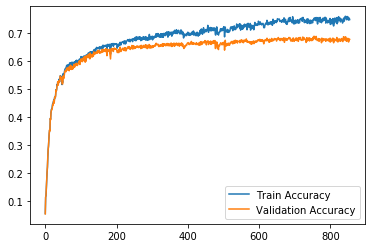

In [30]:
plt.plot(tab_net.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(tab_net.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

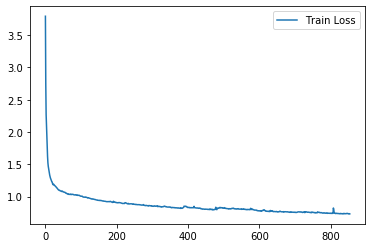

In [31]:
plt.plot(tab_net.history['loss'], label='Train Loss')
plt.legend()
plt.show()

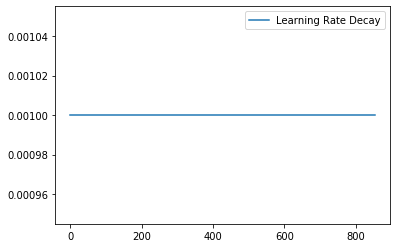

In [32]:
plt.plot(tab_net.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()